In [1]:
from option import args
import torch
import utility
import data
import utils
import model
import loss
from trainer import Trainer
import os
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


number of common Subjects  171


In [2]:
args.no_vols = 2
args.test_vols = 2
# args.tv_en = True
np.random.seed(args.seed)
ids = utils.get_ids()
# ids.sort()
total_vols = args.no_vols+args.test_vols
ids.sort()
ids = ids[:total_vols]
ids = np.random.choice(ids,total_vols,replace = False)
args.thres =0.5 
args.psnr_sim = 25

In [3]:
args

Namespace(block_size=(32, 32, 4), var_blk_size=False, start_var=True, epochs=100, dir='/storage', batch_size=8, sort=True, debug=False, preload=True, ret_points=False, enable_thres=True, thres=0.5, psnr_sim=25, rel_coord=False, patience=3, no_vols=2, test_vols=2, lr=0.005, max_lr=0.01, lr_decay=20, decay_type='step', gamma=0.8, optimizer='ADAM', momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-08, weight_decay=0, start_epoch=0, loss='1*MSE', skip_threshold=100.0, run_name='..', save='DTIArb', load='.', save_models=False, resume=0, print_every=20, save_every=30, cpu=False, gpu=0, seed=1, reset=False, pin_mem=False, model='dmri_rdn', in_chans=7, encoder='rdb', tv=False, attention=False, drop_prob=0, growth=32, model_type='3d', out_chans=5, RDNconfig='C', precision='single', cuda=True, scale=(1, 1, 1), offset=3, stable_epoch=1)

In [4]:
# print(ids)
# if(args.model_type == '2d'):
#     args.block_size = (32,32,1)

# if (args.run_name == '..'):
#     args.run_name = f"{args.model}{args.model_type},{args.encoder},{args.no_vols}_train,{args.test_vols}_test,growth{args.growth},loss_{args.loss},start_var_{args.start_var},batch_size{args.batch_size}"
# else:
#     args.run_name = f"{args.model}{args.model_type},{args.encoder},{args.no_vols}_train,{args.test_vols}_test,growth{args.growth},loss_{args.loss},start_var_{args.start_var},batch_size{args.batch_size},{args.run_name}"
# print(args.run_name)

In [5]:
torch.manual_seed(args.seed)
checkpoint = utility.checkpoint(args)       ## setting the log and the train information
if checkpoint.ok:
    print("ok")

ok


In [6]:
loader = data.Data(args,ids= ids)  
# logger = SummaryWriter('runs/'+ "jupyter")

Loading Done


In [7]:

def interpolate(data,size):
#     print(data.shape)
    if(len(data.shape)==3):
        inp = torch.unsqueeze(data, 0)
#         print(inp.shape)
    else:
        inp = torch.permute(data, (3,0,1,2))
    inp = torch.unsqueeze(inp, 0)
    interpolated = torch.nn.functional.interpolate(inp,size = torch.Size(size))
    interpolated = torch.permute(interpolated, (2,3,4,1,0))
    
    if(len(data.shape)==3):
        interpolated = torch.squeeze(interpolated)
    return torch.squeeze(interpolated)
    

def pnts_cord(x,pos):
    if(pos == 2):
        a,b = x[0],x[2]
        w,d = x[1]-x[0],x[3]-x[2]
        s = x[4] + (x[5]-x[4])//2
        return a,b,w,d,s
    if(pos == 0):
        a,b = x[2],x[4]
        w,d = x[3]-x[2],x[5]-x[4]
        s = x[0] + (x[1]-x[0])//2
        return a,b,w,d,s
    if(pos == 1):
        a,b = x[0],x[4]
        w,d = x[1]-x[0],x[5]-x[4]
        s = x[2] + (x[3]-x[2])//2
        return a,b,w,d,s


def align(lr,hr):
    temp  = lr.shape[1:4]
    pos = temp.index(min(temp))
#     print(pos,temp)
    if(pos == 1):
        lr = np.transpose(lr,(0,1,3,2,4))
        hr = np.transpose(hr,(0,1,3,2,4))
    elif(pos == 0):
        lr = np.transpose(lr,(0,2,3,1,4))
        hr = np.transpose(hr,(0,2,3,1,4))
    return lr,hr,pos



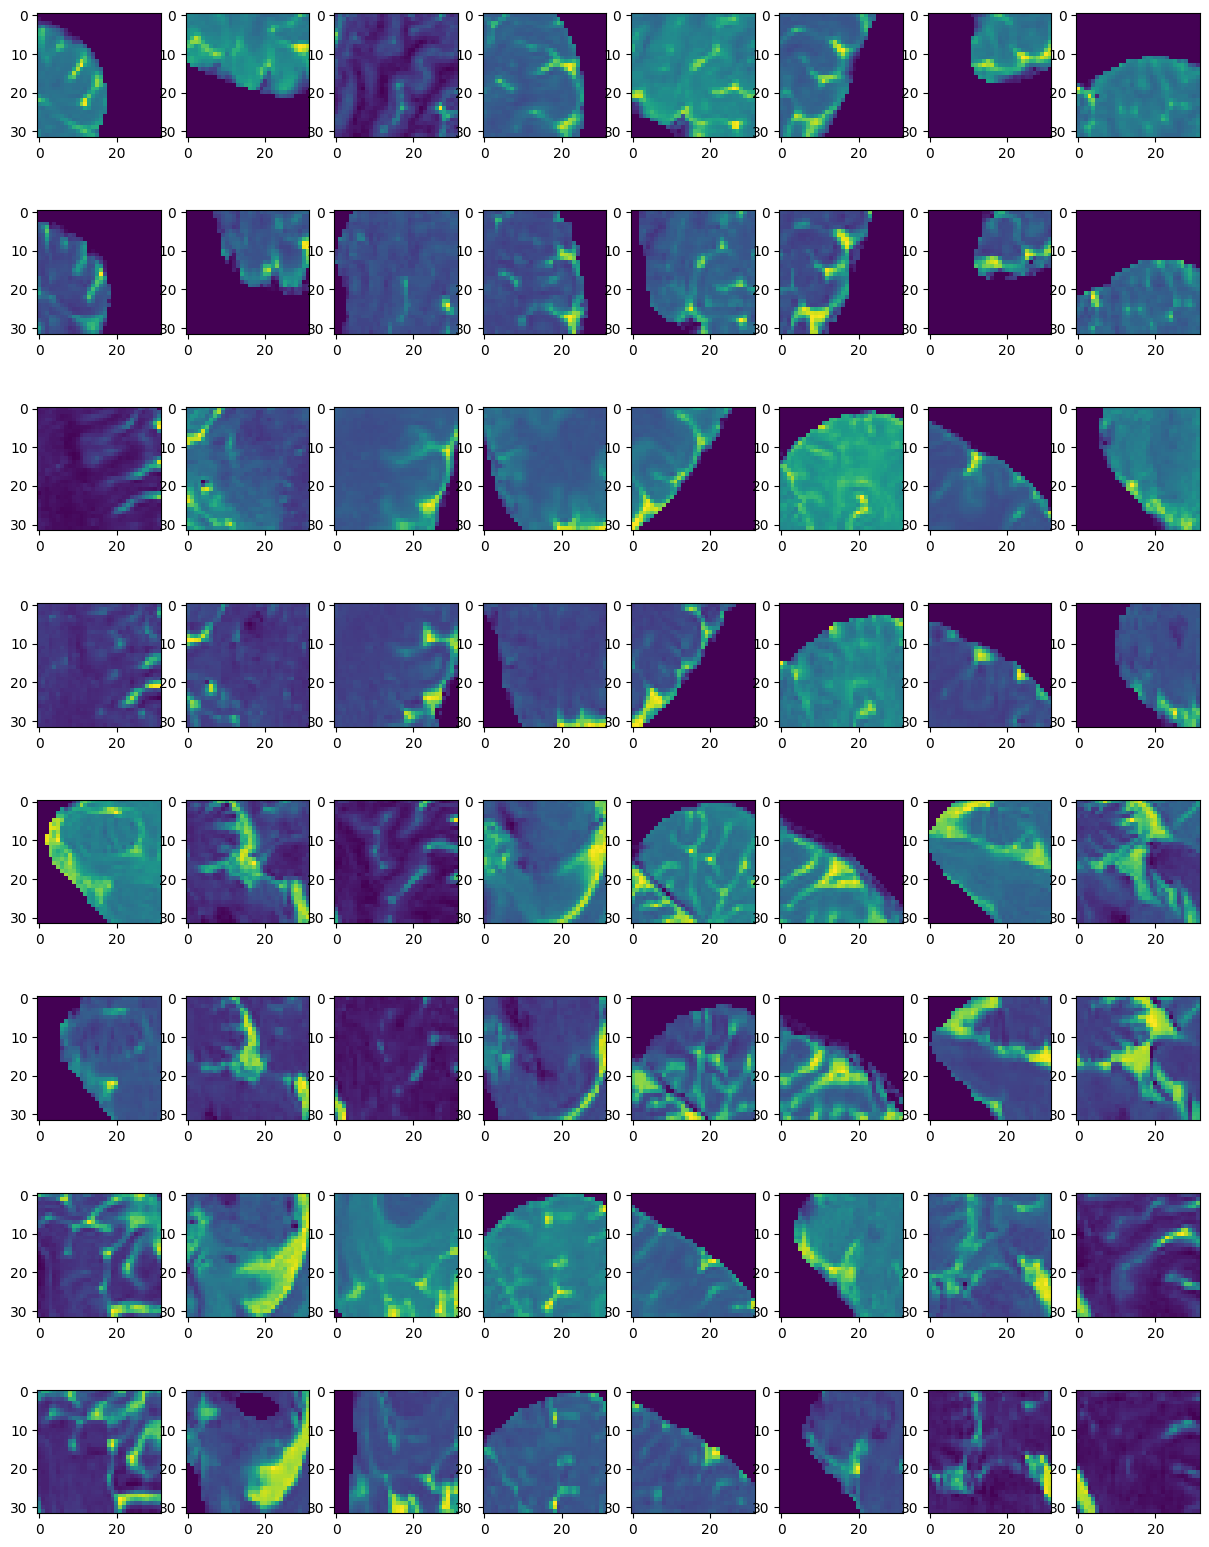

In [8]:

%matplotlib inline
fig, ax = plt.subplots(8,8)

fig.set_figheight(4*5)
# set width of each subplot as 8
fig.set_figwidth(15)
for batch, (lr, hr,scale,rel_coor,out) in enumerate(loader.testing_data):
    lr = lr.squeeze().float().numpy()
    hr = hr.squeeze().float().numpy()
    out = out.squeeze().float().numpy()
    out,hr,pos = align(out,hr)
#     print(batch)
    temp = 2*batch
    for i in range(8):
        ax[temp][i].imshow(out[i,:,:,0,0])
        ax[temp+1][i].imshow(hr[i,:,:,0,0])
    if(batch == 3):
        break
